In [24]:
# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

import plotly.express as px

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

#import os as os; os.remove('paper-Ftable.pkl')
%run utils/Paper_Histogramas_Configuracion.ipynb

[*] => catalogue <= [*]
[*] Se carga el archivo: paper-Ftable.pkl
       Cantidad de datos: 662945 (tablas/photo_fornax_23fields_catalog_v13sep2021_dec_corr.fits)

       Cantidad de datos filtrados: 9115

[*] => Fornax
       Cantidad de datos: 244 (tablas/photo_fornax_literature_catalog_v13sep2021_dec_corr_v2_extinc.fits)
       Cantidad de datos filtrados: 144

[*] => Background (cross-match de 3 arcsec)
       Se encontraron 282 fuentes duplicadas (ID)
       Cantidad de datos: 1353 (tablas/SpecZ_Catalogue_V6_Fornax.fits)

[*] => SPLUS
       Cantidad de datos: 7631


---

In [28]:
# Modifico el THETA_IMAGE para que abarque 0 a pi/2 y agrego el label
for tabla, label in zip([ Fornax, Background, Splus ], [ 'Fornax', 'Background', 'Splus' ]):
    tabla['THETA_IMAGE2'] = tabla.apply ( lambda x: 180.0 - np.abs(x['THETA_IMAGE']) if x['THETA_IMAGE'] < 0 else x['THETA_IMAGE'], axis = 1 )
    tabla['label'] = label

    list = []
    for pair in itertools.combinations ( filters, r = 2 ):
        tabla[ pair[0] + '-' + pair[1] ] = tabla [ pair[0] ] - tabla [ pair[1] ]
        list.append(pair[0] + '-' + pair[1])
#
columnas = filters.copy() 
columnas.extend(['label'])
datos = pd.concat ( [Splus[columnas], Fornax[columnas], Background[columnas]], ignore_index = True )

# Le saco el label >> reemplazo los valores mayores a 30 con NAN >> le saco las filas que tengan al menos un NAN
df = datos.drop( ['label'], axis = 1 )
datos = pd.concat( [ df[ (df < 30) ], datos['label'].squeeze() ], axis = 1 ).dropna()

In [29]:
datos

U_auto  F378_auto  F395_auto  F410_auto  F430_auto     G_auto  \
0     20.454686  20.283616  18.832224  18.834496  19.033933  19.014059   
1     19.624175  19.149825  18.810833  18.548520  18.545655  17.926271   
5     20.025730  19.497379  19.294464  19.486176  18.752038  18.406900   
6     19.825183  18.714534  18.514649  18.196403  18.145057  17.595008   
7     23.516255  20.435327  19.032576  22.777716  21.921048  19.722656   
...         ...        ...        ...        ...        ...        ...   
9123  18.540462  18.225365  17.970210  17.652984  17.378623  17.096454   
9124  18.522634  18.208486  18.069837  17.835260  17.339268  16.834349   
9125  18.719702  18.351800  17.931200  18.034530  17.221312  17.048963   
9126  18.611389  18.250520  17.774802  17.679479  17.307350  16.679898   
9127  18.517620  18.364622  17.765054  17.741176  17.364173  16.642341   

      F515_auto     R_auto  F660_auto     I_auto  F861_auto     Z_auto  \
0     18.850675  18.912694  19.154460  19.024936  18.316691  18.526115   
1     17.770725  17.300041  17.159240  16.899342  16.693286  16.634336   
5     18.258252  17.432434  17.280906  17.007642  16.768469  16.748036   
6     17.234968  16.720502  16.580819  16.295428  16.052310  16.023297   
7     19.398810  18.403537  18.249951  17.919032  17.640494  17.576731   
...         ...        ...        ...        ...        ...        ...   
9123  16.916597  16.495107  16.416362  16.076925  15.897171  15.856787   
9124  16.642102  16.205635  16.091010  15.804034  15.679673  15.577921   
9125  16.720775  16.328593  16.275599  15.896648  15.721288  15.669297   
9126  16.266351  15.866719  15.756267  15.450416  15.217227  15.172014   
9127  16.327566  15.810038  15.730836  15.393993  15.196033  15.102870   

           label  
0          Splus  
1          Splus  
5          Splus  
6          Splus  
7          Splus  
...          ...  
9123  Background  
9124  Background  
9125  Background  
9126  Background  
9127  Background  

[6746 rows x 13 columns]

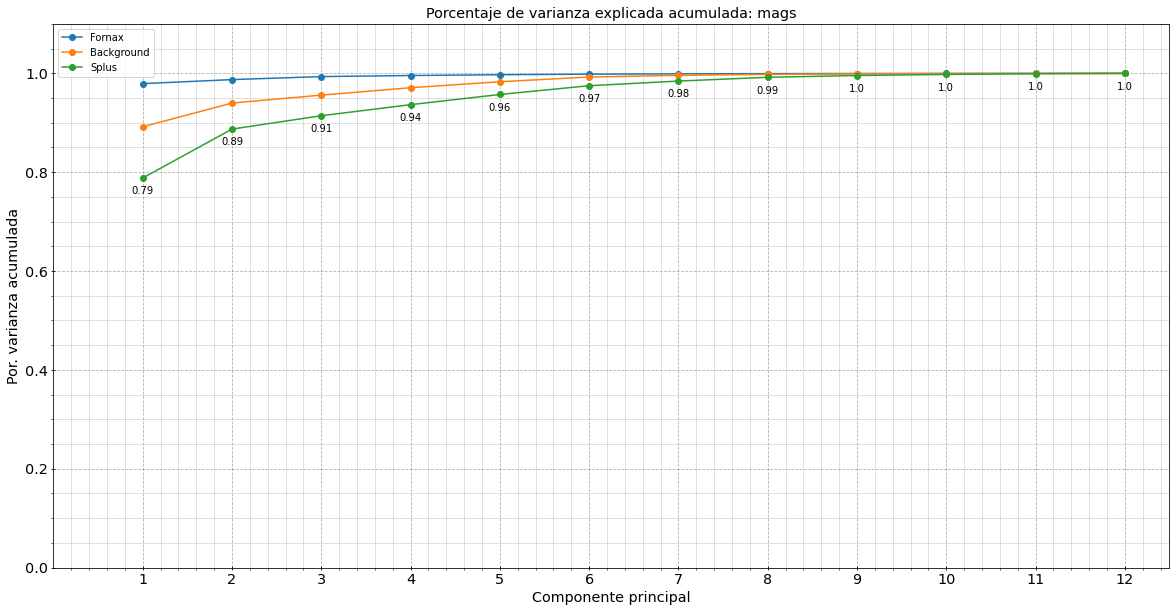

In [83]:
features = [ x for x in datos if x != 'label' ]
prop_varianza_acum = [ ] 
prop_varianza_ratio = [ ] 
prop_components = [ ] 

for l in [ 'Fornax', 'Background', 'Splus' ]:
    data = datos [ datos['label'] == l ][features]

    # Entrenamiento modelo PCA con escalado de los datos
    # ==============================================================================
    pca_pipe = make_pipeline(StandardScaler(), PCA())
    pca_pipe.fit(data)

    # Se extrae el modelo entrenado del pipeline
    modelo_pca = pca_pipe.named_steps['pca']

    # Porcentaje de varianza explicada acumulada
    # ==============================================================================
    prop_varianza_acum.append ( modelo_pca.explained_variance_ratio_.cumsum() )
    prop_varianza_ratio.append ( modelo_pca.explained_variance_ratio_ )
    prop_components.append ( modelo_pca.components_ )

fig, ax = plt.subplots ( nrows = 1, ncols = 1, figsize = (20, 10) )

for i, l in enumerate([ 'Fornax', 'Background', 'Splus' ]):
    ax.plot(
        np.arange(len(data.columns)) + 1,
        prop_varianza_acum[i],
        marker = 'o',
        label = l
    )

for x, y in zip(np.arange(len(data.columns)) + 1, prop_varianza_acum[2]):
    labelp = round(y, 2)
    ax.annotate(
        labelp,
        (x,y),
        textcoords = "offset points",
        xytext = (0,-16),
        ha = 'center'
    )

ax.minorticks_on()
ax.grid ( b = True, which = 'major', color = 'black', linestyle = '--', alpha = 0.3, zorder = 0.0 )
ax.grid ( b = True, which = 'minor', color = 'gray', linestyle = '-', alpha = 0.3, zorder = 0.0 )
ax.tick_params ( axis = "y", direction = "inout" )
ax.tick_params ( axis = "x", direction = "inout" )

ax.set_ylim(0, 1.1)
ax.set_xlim(0, 12.5)
ax.set_xticks(np.arange(12) + 1.0) # (np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada: mags')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada')
ax.legend()
plt.savefig ( "figures/PCA-mags-01.jpg", dpi = 250, facecolor = 'w', edgecolor = 'w',
            orientation = 'portrait', format = None, transparent = False, 
            bbox_inches = 'tight', pad_inches = 0.01 )
plt.show()

In [82]:
var_exp = pd.DataFrame()
#
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
for i, l in enumerate([ 'Fornax', 'Background', 'Splus' ]):
    var_exp.loc[:, l] = pd.Series( prop_varianza_ratio[i], name = l, index = [ "PC" + str(j+1) for j in range(len(prop_varianza_ratio[i])) ] )

var_exp

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------


Fornax  Background     Splus
PC1   0.979216    0.891942  0.788259
PC2   0.008161    0.047955  0.098989
PC3   0.006105    0.016064  0.027035
PC4   0.002166    0.014999  0.022364
PC5   0.001634    0.012145  0.020628
PC6   0.001117    0.009454  0.017709
PC7   0.000663    0.003452  0.009418
PC8   0.000389    0.001970  0.007666
PC9   0.000272    0.000980  0.003579
PC10  0.000128    0.000579  0.002210
PC11  0.000111    0.000268  0.001461
PC12  0.000036    0.000193  0.000681

In [98]:
comp = pd.DataFrame()

for i, l in enumerate([ 'Fornax', 'Background', 'Splus' ]):
    print (l)
    # Se combierte el array a dataframe para añadir nombres a los ejes.
    display ( pd.DataFrame ( data = prop_components[i], columns = data.columns, index = [ "PC" + str(j+1) for j in range(len(prop_components[i])) ] ) )

Fornax


U_auto  F378_auto  F395_auto  F410_auto  F430_auto    G_auto  \
PC1   0.284092   0.287630   0.280771   0.288967   0.289352  0.291121   
PC2  -0.398868  -0.289064  -0.607578  -0.104228  -0.064398  0.062863   
PC3  -0.595903  -0.250543   0.705856  -0.217482   0.030758 -0.068060   
PC4   0.592183  -0.352043   0.174812  -0.489573  -0.394294 -0.016544   
PC5   0.209565  -0.731297  -0.012545   0.195228   0.584835  0.020505   
PC6  -0.034124  -0.308925   0.115251   0.712389  -0.578166  0.101052   
PC7   0.047234   0.094791   0.059548   0.232585   0.189374 -0.421648   
PC8  -0.047626  -0.002075  -0.044922  -0.107389   0.198256  0.326612   
PC9  -0.047496  -0.046120   0.010412  -0.005444  -0.041872  0.515079   
PC10  0.023991   0.039063  -0.016985   0.074760  -0.040340 -0.245734   
PC11  0.044736  -0.063466  -0.056399   0.042371   0.025398 -0.520255   
PC12 -0.001104  -0.010185  -0.025356  -0.000845   0.014555  0.122228   

      F515_auto    R_auto  F660_auto    I_auto  F861_auto    Z_auto  
PC1    0.291047  0.290824   0.290820  0.290178   0.289757  0.289353  
PC2    0.068861  0.216181   0.141900  0.288588   0.325743  0.328984  
PC3    0.048800  0.056009   0.035008  0.110415   0.061870  0.090857  
PC4   -0.003581  0.042483  -0.062711  0.148689   0.156320  0.217042  
PC5   -0.071585  0.023939   0.045910 -0.038268  -0.060623 -0.166185  
PC6    0.114919 -0.078326  -0.107282 -0.024548   0.081340  0.007936  
PC7   -0.493588 -0.161281  -0.357114  0.114998   0.183059  0.523055  
PC8    0.473016 -0.220241  -0.737536 -0.041523   0.104685  0.096454  
PC9   -0.288648  0.237042  -0.059598 -0.101578  -0.616033  0.442207  
PC10   0.047156  0.500151  -0.367335  0.596316  -0.314247 -0.297246  
PC11   0.579793 -0.005314   0.148694 -0.184647  -0.409219  0.397281  
PC12   0.027400 -0.690037   0.210775  0.617409  -0.284956  0.019450

Background


U_auto  F378_auto  F395_auto  F410_auto  F430_auto    G_auto  \
PC1  -0.268105  -0.276625  -0.267002  -0.273233  -0.287306 -0.302834   
PC2  -0.447479  -0.331743  -0.398304  -0.294880  -0.172939  0.024817   
PC3  -0.084326  -0.093314   0.779377  -0.597498  -0.115548 -0.016927   
PC4  -0.614043  -0.236729   0.390216   0.638018  -0.018805 -0.049905   
PC5  -0.529077   0.828040  -0.071084  -0.159606   0.034877  0.004226   
PC6  -0.200378  -0.219908  -0.057708  -0.209088   0.916976  0.026831   
PC7  -0.127389  -0.085175  -0.025394  -0.042869  -0.137366  0.125637   
PC8   0.076214   0.078405   0.032613   0.042679   0.110468 -0.779263   
PC9  -0.036730  -0.034334  -0.014397  -0.034958  -0.008047  0.355367   
PC10  0.015567   0.004142   0.004768  -0.005956   0.016517 -0.364174   
PC11 -0.004667  -0.007793  -0.003528   0.014355  -0.004776  0.086115   
PC12  0.000217   0.002892   0.005726  -0.002027  -0.018646 -0.121657   

      F515_auto    R_auto  F660_auto    I_auto  F861_auto    Z_auto  
PC1   -0.299498 -0.300990  -0.299688 -0.297766  -0.293820 -0.293763  
PC2    0.077496  0.214804   0.242190  0.285128   0.325048  0.340336  
PC3   -0.013790  0.007223   0.027645  0.030641   0.037490  0.052553  
PC4   -0.064344 -0.012027  -0.017470  0.001873   0.007721 -0.008806  
PC5   -0.019323 -0.016157  -0.009862 -0.021197  -0.028285 -0.026182  
PC6    0.018871 -0.021545  -0.045754 -0.071773  -0.106600 -0.058714  
PC7    0.900783 -0.016785  -0.036192 -0.134004  -0.251022 -0.213094  
PC8    0.287224 -0.219706  -0.119940 -0.037133   0.451695  0.123056  
PC9   -0.025810 -0.108456  -0.096663 -0.154928   0.710646 -0.564711  
PC10  -0.057776  0.276244   0.602630  0.222605  -0.122701 -0.599472  
PC11  -0.018017 -0.416281   0.672101 -0.564862   0.032856  0.216281  
PC12  -0.031600  0.743254  -0.091374 -0.641509   0.078686  0.072853

Splus


U_auto  F378_auto  F395_auto  F410_auto  F430_auto    G_auto  \
PC1  -0.259039  -0.259002  -0.251873  -0.269416  -0.277087 -0.315596   
PC2  -0.379855  -0.366691  -0.338222  -0.298442  -0.274168  0.012790   
PC3  -0.221404  -0.086743   0.890459  -0.308667  -0.204449 -0.065359   
PC4  -0.300689  -0.665858   0.143769   0.566167   0.345154  0.019967   
PC5   0.752821  -0.579517   0.034997  -0.305158   0.019695  0.037257   
PC6  -0.221815   0.034963  -0.052204  -0.557079   0.792822  0.049043   
PC7  -0.025609   0.005623   0.028088  -0.013322  -0.057648  0.531024   
PC8  -0.176183  -0.099084  -0.049873  -0.132103  -0.228989  0.354614   
PC9   0.021859   0.004218  -0.016035   0.030406   0.022507 -0.242716   
PC10 -0.026218  -0.020233  -0.031643  -0.011476  -0.027228  0.490936   
PC11 -0.018084  -0.014108  -0.009211  -0.019307  -0.034059  0.394991   
PC12 -0.006762  -0.005179  -0.003151   0.003353   0.001707  0.167595   

      F515_auto    R_auto  F660_auto    I_auto  F861_auto    Z_auto  
PC1   -0.312587 -0.311242  -0.309811 -0.302041  -0.296696 -0.289122  
PC2   -0.021203  0.227727   0.226112  0.319238   0.303991  0.380389  
PC3   -0.039342 -0.021439  -0.016414  0.023075   0.059916  0.052856  
PC4    0.008395 -0.006591  -0.013190 -0.038099  -0.043043 -0.043391  
PC5    0.029085  0.014238   0.005073  0.006073  -0.010197 -0.009108  
PC6    0.038559  0.000702  -0.017091 -0.026204  -0.046178 -0.030719  
PC7   -0.354224  0.333125  -0.237098  0.186645  -0.595464  0.175957  
PC8    0.743716  0.086988   0.068770 -0.133093  -0.222988 -0.358008  
PC9    0.452669 -0.156845  -0.546818  0.026617  -0.169539  0.617198  
PC10  -0.077826 -0.153176  -0.594099 -0.001505   0.592341 -0.150558  
PC11  -0.088910 -0.381245   0.331390 -0.615329   0.003161  0.447354  
PC12   0.020715 -0.733902   0.171469  0.610131  -0.167208 -0.056149

In [137]:
l_train = 'Fornax'
train = datos [ datos['label'] == l_train ][features]

# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit ( train )

# Proyección de las observaciones de entrenamiento
# ==============================================================================
l = 'Splus'
data = datos [ datos['label'] == l ][features]

proyecciones = pca_pipe.transform( X = data )
proyecciones = pd.DataFrame ( proyecciones, columns = [ "PC" + str(j+1) for j in range(len(data.columns)) ] )
proyecciones#.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0     6.553207  0.410970 -0.356271  0.063859 -0.333849 -0.329861 -0.121306   
1     4.561042 -0.391549 -0.229864 -0.218932  0.042584 -0.084071 -0.027289   
2     5.129722 -0.636393 -0.320927 -0.383431  0.081844  0.208315 -0.063402   
3     3.832044 -0.641394 -0.405280 -0.067924  0.154102 -0.058462 -0.022869   
4     7.700660 -1.085047 -1.809944 -0.814039  1.283903  0.323326  0.296956   
...        ...       ...       ...       ...       ...       ...       ...   
5429  6.553256  1.658164  0.120560  0.138426 -0.060777  0.076677 -0.277173   
5430  7.946346  1.300870 -0.140552  0.041130 -0.223168  0.323735 -0.361004   
5431  6.703473  1.748431  0.093855  0.286792 -0.211278  0.108228 -0.416870   
5432  2.644145  1.295645  0.054492  0.454784  0.192320 -0.096860 -0.490999   
5433  6.258378  1.779907  0.184637  0.331868 -0.271637  0.186943 -0.081372   

           PC8       PC9      PC10      PC11      PC12  
0    -0.246751 -0.038358  0.131107  0.049814  0.151783  
1     0.063374 -0.035031  0.064348  0.035559 -0.009237  
2     0.153525  0.000201  0.072796  0.067221  0.010080  
3     0.082541  0.013968  0.052218  0.003714  0.004933  
4     0.311161 -0.066171  0.146863  0.204467  0.055134  
...        ...       ...       ...       ...       ...  
5429 -0.482201  0.284800  0.211472 -0.089580  0.108829  
5430 -0.264389  0.121223  0.075290 -0.171388  0.002390  
5431 -0.414971  0.285902  0.125267 -0.050759  0.109587  
5432 -0.296409  0.448932  0.019139 -0.271859  0.083171  
5433 -0.301933  0.322456 -0.151528  0.113324  0.019528  

[5434 rows x 12 columns]

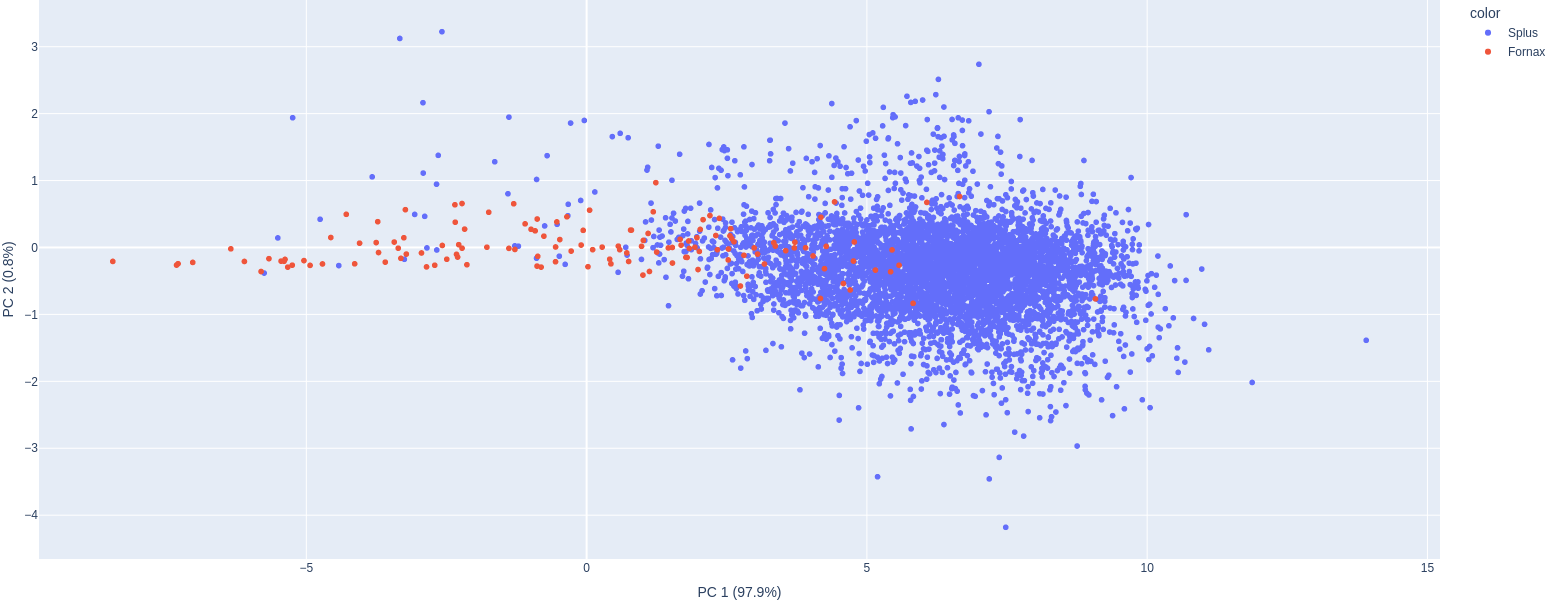

In [195]:
l_train = 'Fornax'
train = datos [ datos['label'] == l_train ][features]

# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit ( train )

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']
    
d = datos[ (datos['label'] == 'Fornax') | (datos['label'] == 'Splus') ]
d.sort_values ( by = 'label', key = lambda x: x.map({'Background': 0, 'Splus': 1, 'Fornax': 3} ), inplace = True )
#
components = pca_pipe.transform ( d[features] )

labels = [ f"PC {i+1} ({var:.1f}%)" for i, var in enumerate(modelo_pca.explained_variance_ratio_ * 100) ]

fig = px.scatter ( x = components[:,0], y = components[:,1], color = d['label'] )
fig.update_layout ( xaxis_title = labels[0], yaxis_title = labels[1], autosize = False, 
                   width = 600, height = 600, showlegend = True, margin = {"l":0,"r":0,"t":0,"b":0} )

fig.write_html("figures/PCA-mags-02-Splus_Fornax.html")
fig.write_image("figures/PCA-mags-02-Splus_Fornax.jpeg")
fig.show()

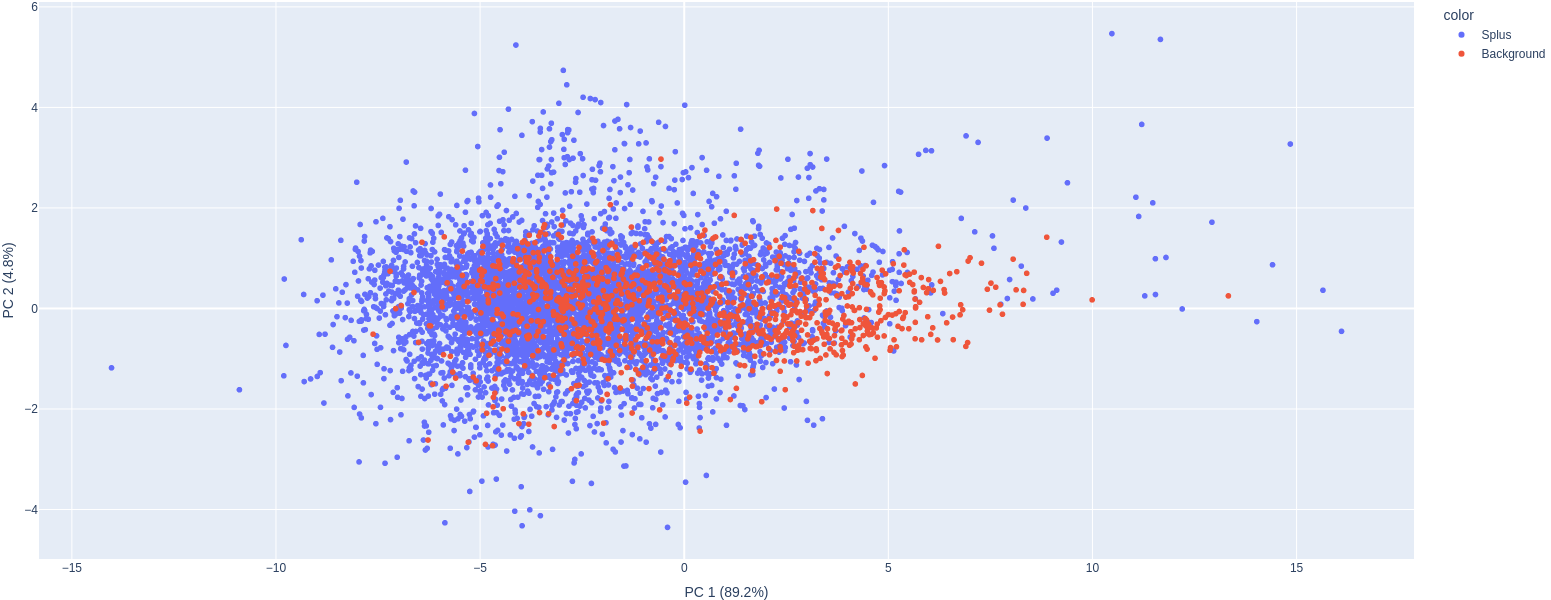

In [197]:
l_train = 'Background'
train = datos [ datos['label'] == l_train ][features]

# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit ( train )

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']
    
d = datos[ (datos['label'] == 'Background') | (datos['label'] == 'Splus') ]
d.sort_values ( by = 'label', key = lambda x: x.map({'Fornax': 0, 'Splus': 1, 'Background': 3} ), inplace = True )
#
components = pca_pipe.transform ( d[features] )

labels = [ f"PC {i+1} ({var:.1f}%)" for i, var in enumerate(modelo_pca.explained_variance_ratio_ * 100) ]

fig = px.scatter ( x = components[:,0], y = components[:,1], color = d['label'] )
fig.update_layout ( xaxis_title = labels[0], yaxis_title = labels[1], autosize = False, 
                   width = 600, height = 600, showlegend = True, margin = {"l":0,"r":0,"t":0,"b":0} )

fig.write_html("figures/PCA-mags-02-Splus_Background.html")
fig.write_image("figures/PCA-mags-02-Splus_Background.jpeg")
fig.show()

In [194]:
labels = [ f"PC {i+1} ({var:.1f}%)" for i, var in enumerate(modelo_pca.explained_variance_ratio_ * 100) ]
labels[0]

'PC 1 (97.9%)'

In [188]:
labels.values()

dict_values(['PC 1 (97.9%)', 'PC 2 (0.8%)', 'PC 3 (0.6%)', 'PC 4 (0.2%)', 'PC 5 (0.2%)', 'PC 6 (0.1%)', 'PC 7 (0.1%)', 'PC 8 (0.0%)', 'PC 9 (0.0%)', 'PC 10 (0.0%)', 'PC 11 (0.0%)', 'PC 12 (0.0%)'])

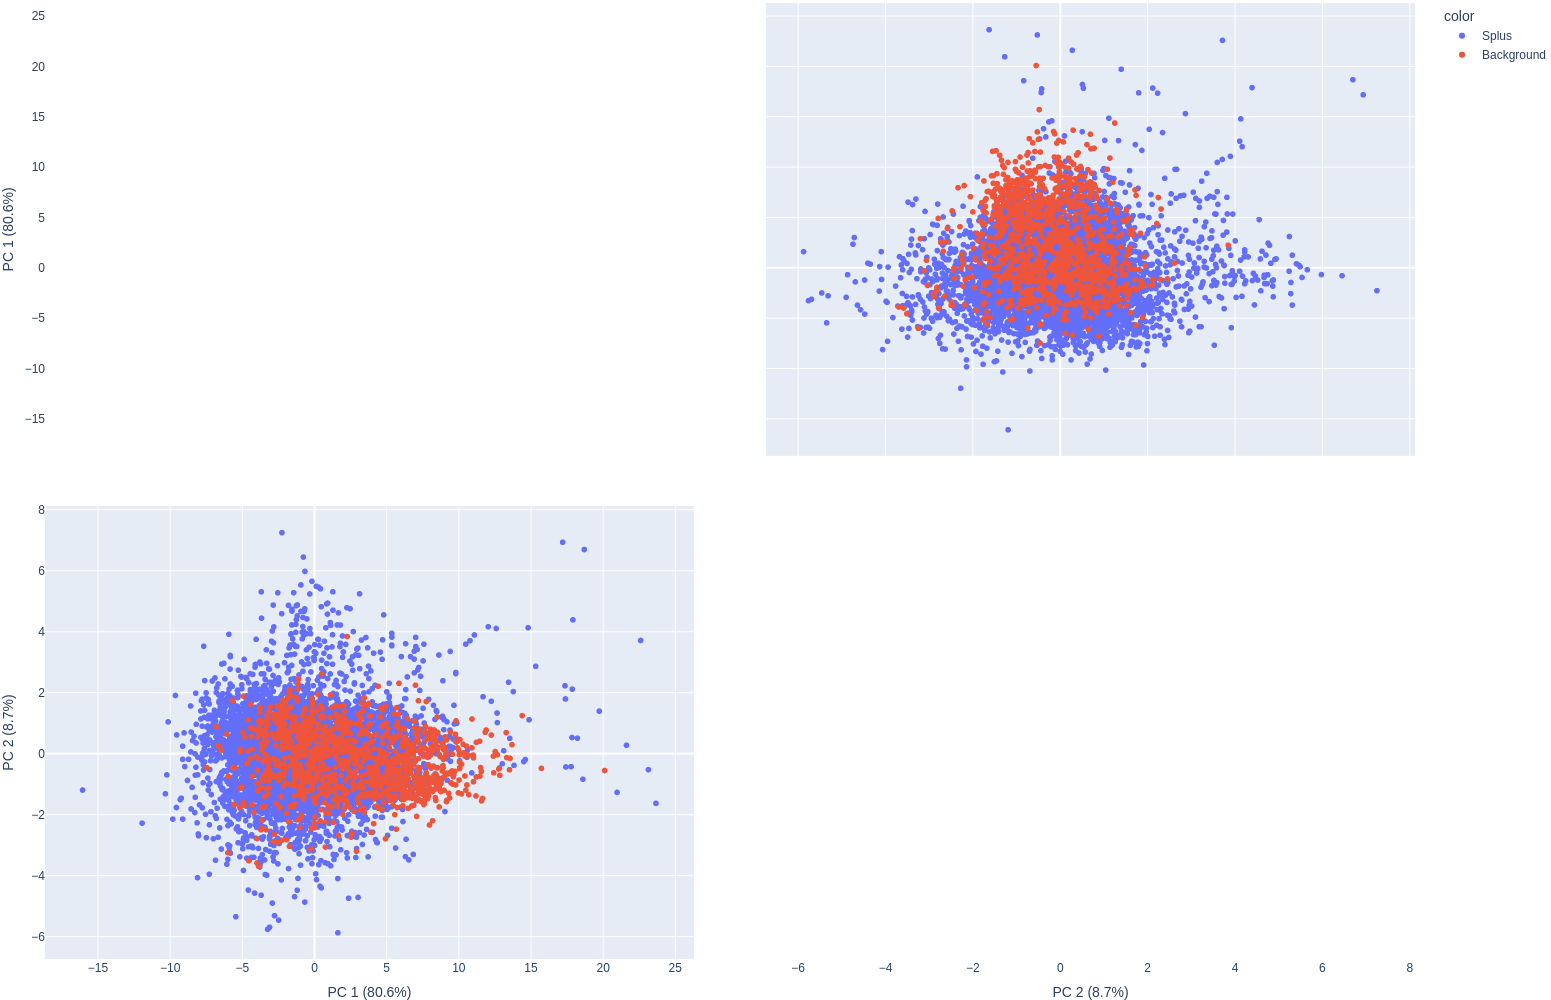

In [115]:
d = datos[ (datos['label'] == 'Background') | (datos['label'] == 'Splus') ]
d.sort_values ( by = 'label', key = lambda x: x.map({'Fornax': 0, 'Splus': 1, 'Background': 3} ), inplace = True )

pca = PCA()
components = pca.fit_transform ( d[features] )

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(2),
    color=d['label']
)
fig.update_layout(autosize=False, width=1000, height=1000, showlegend=True, margin={"l":0,"r":0,"t":0,"b":0})

fig.update_traces(diagonal_visible=False)
fig.write_html("figures/PCA-mags-02-Splus_Background.html")
fig.write_image("figures/PCA-mags-02-Splus_Background.jpeg")
fig.show()

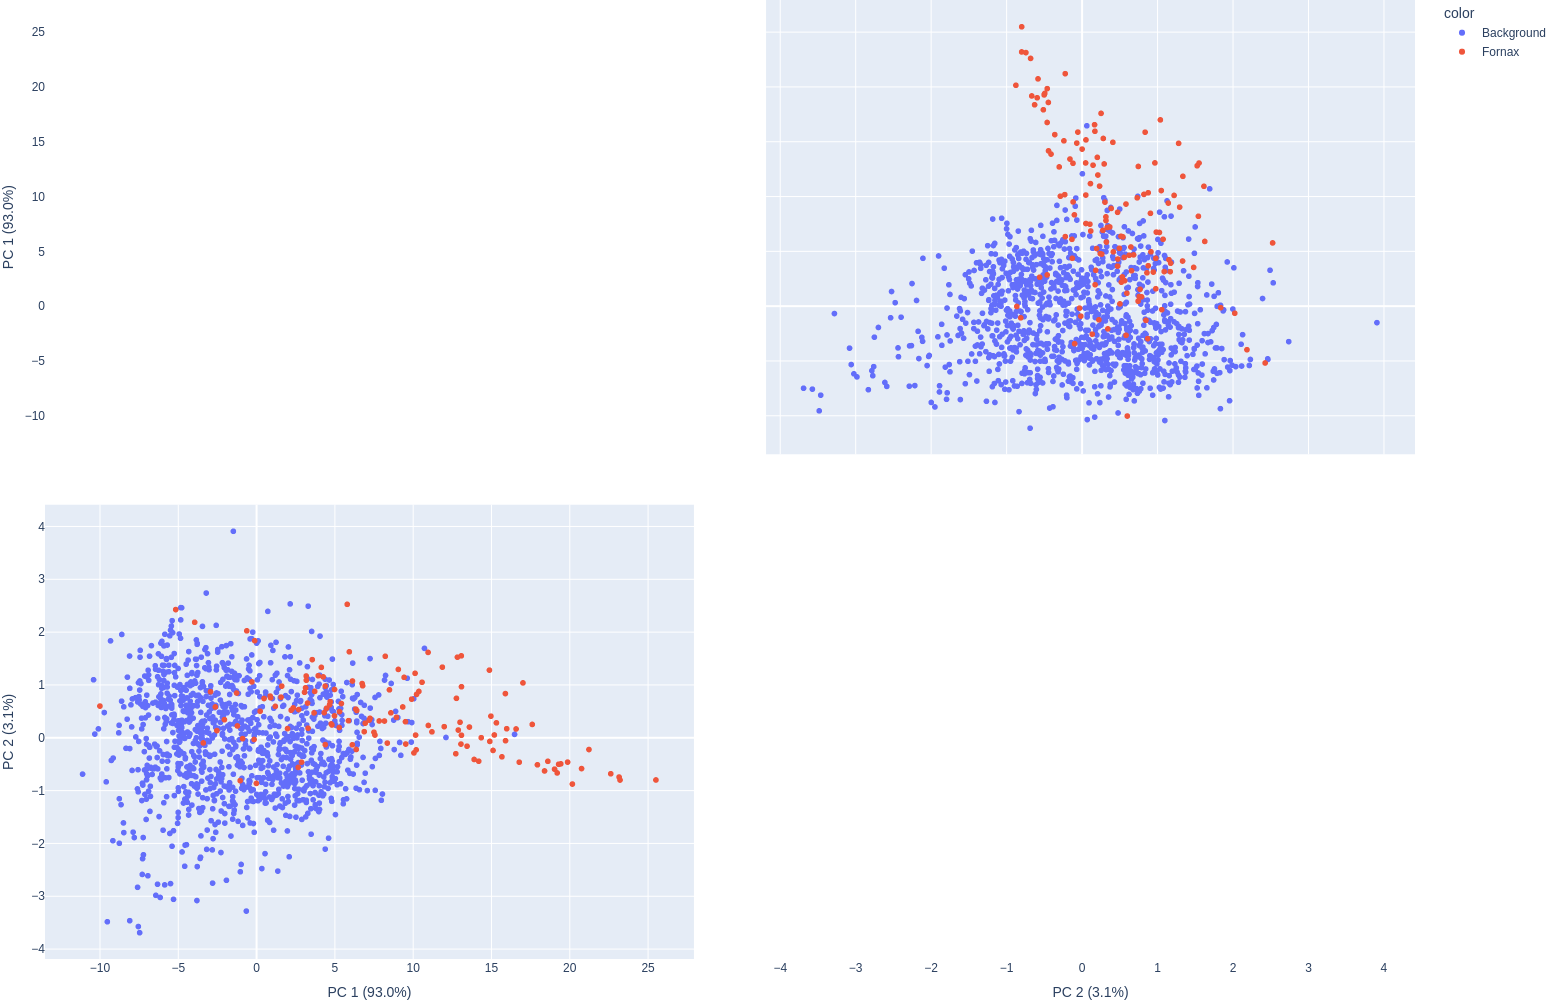

In [116]:
d = datos[ (datos['label'] == 'Background') | (datos['label'] == 'Fornax') ]
d.sort_values ( by = 'label', key = lambda x: x.map({'Background': 0, 'Splus': 1, 'Fornax': 3} ), inplace = True )

pca = PCA()
components = pca.fit_transform ( d[features] )

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(2),
    color=d['label']
)
fig.update_layout(autosize=False, width=1000, height=1000, showlegend=True, margin={"l":0,"r":0,"t":0,"b":0})

fig.update_traces(diagonal_visible=False)
fig.write_html("figures/PCA-mags-02-Background_Fornax.html")
fig.write_image("figures/PCA-mags-02-Background_Fornax.jpeg")
fig.show()

Fornax
Background
Splus


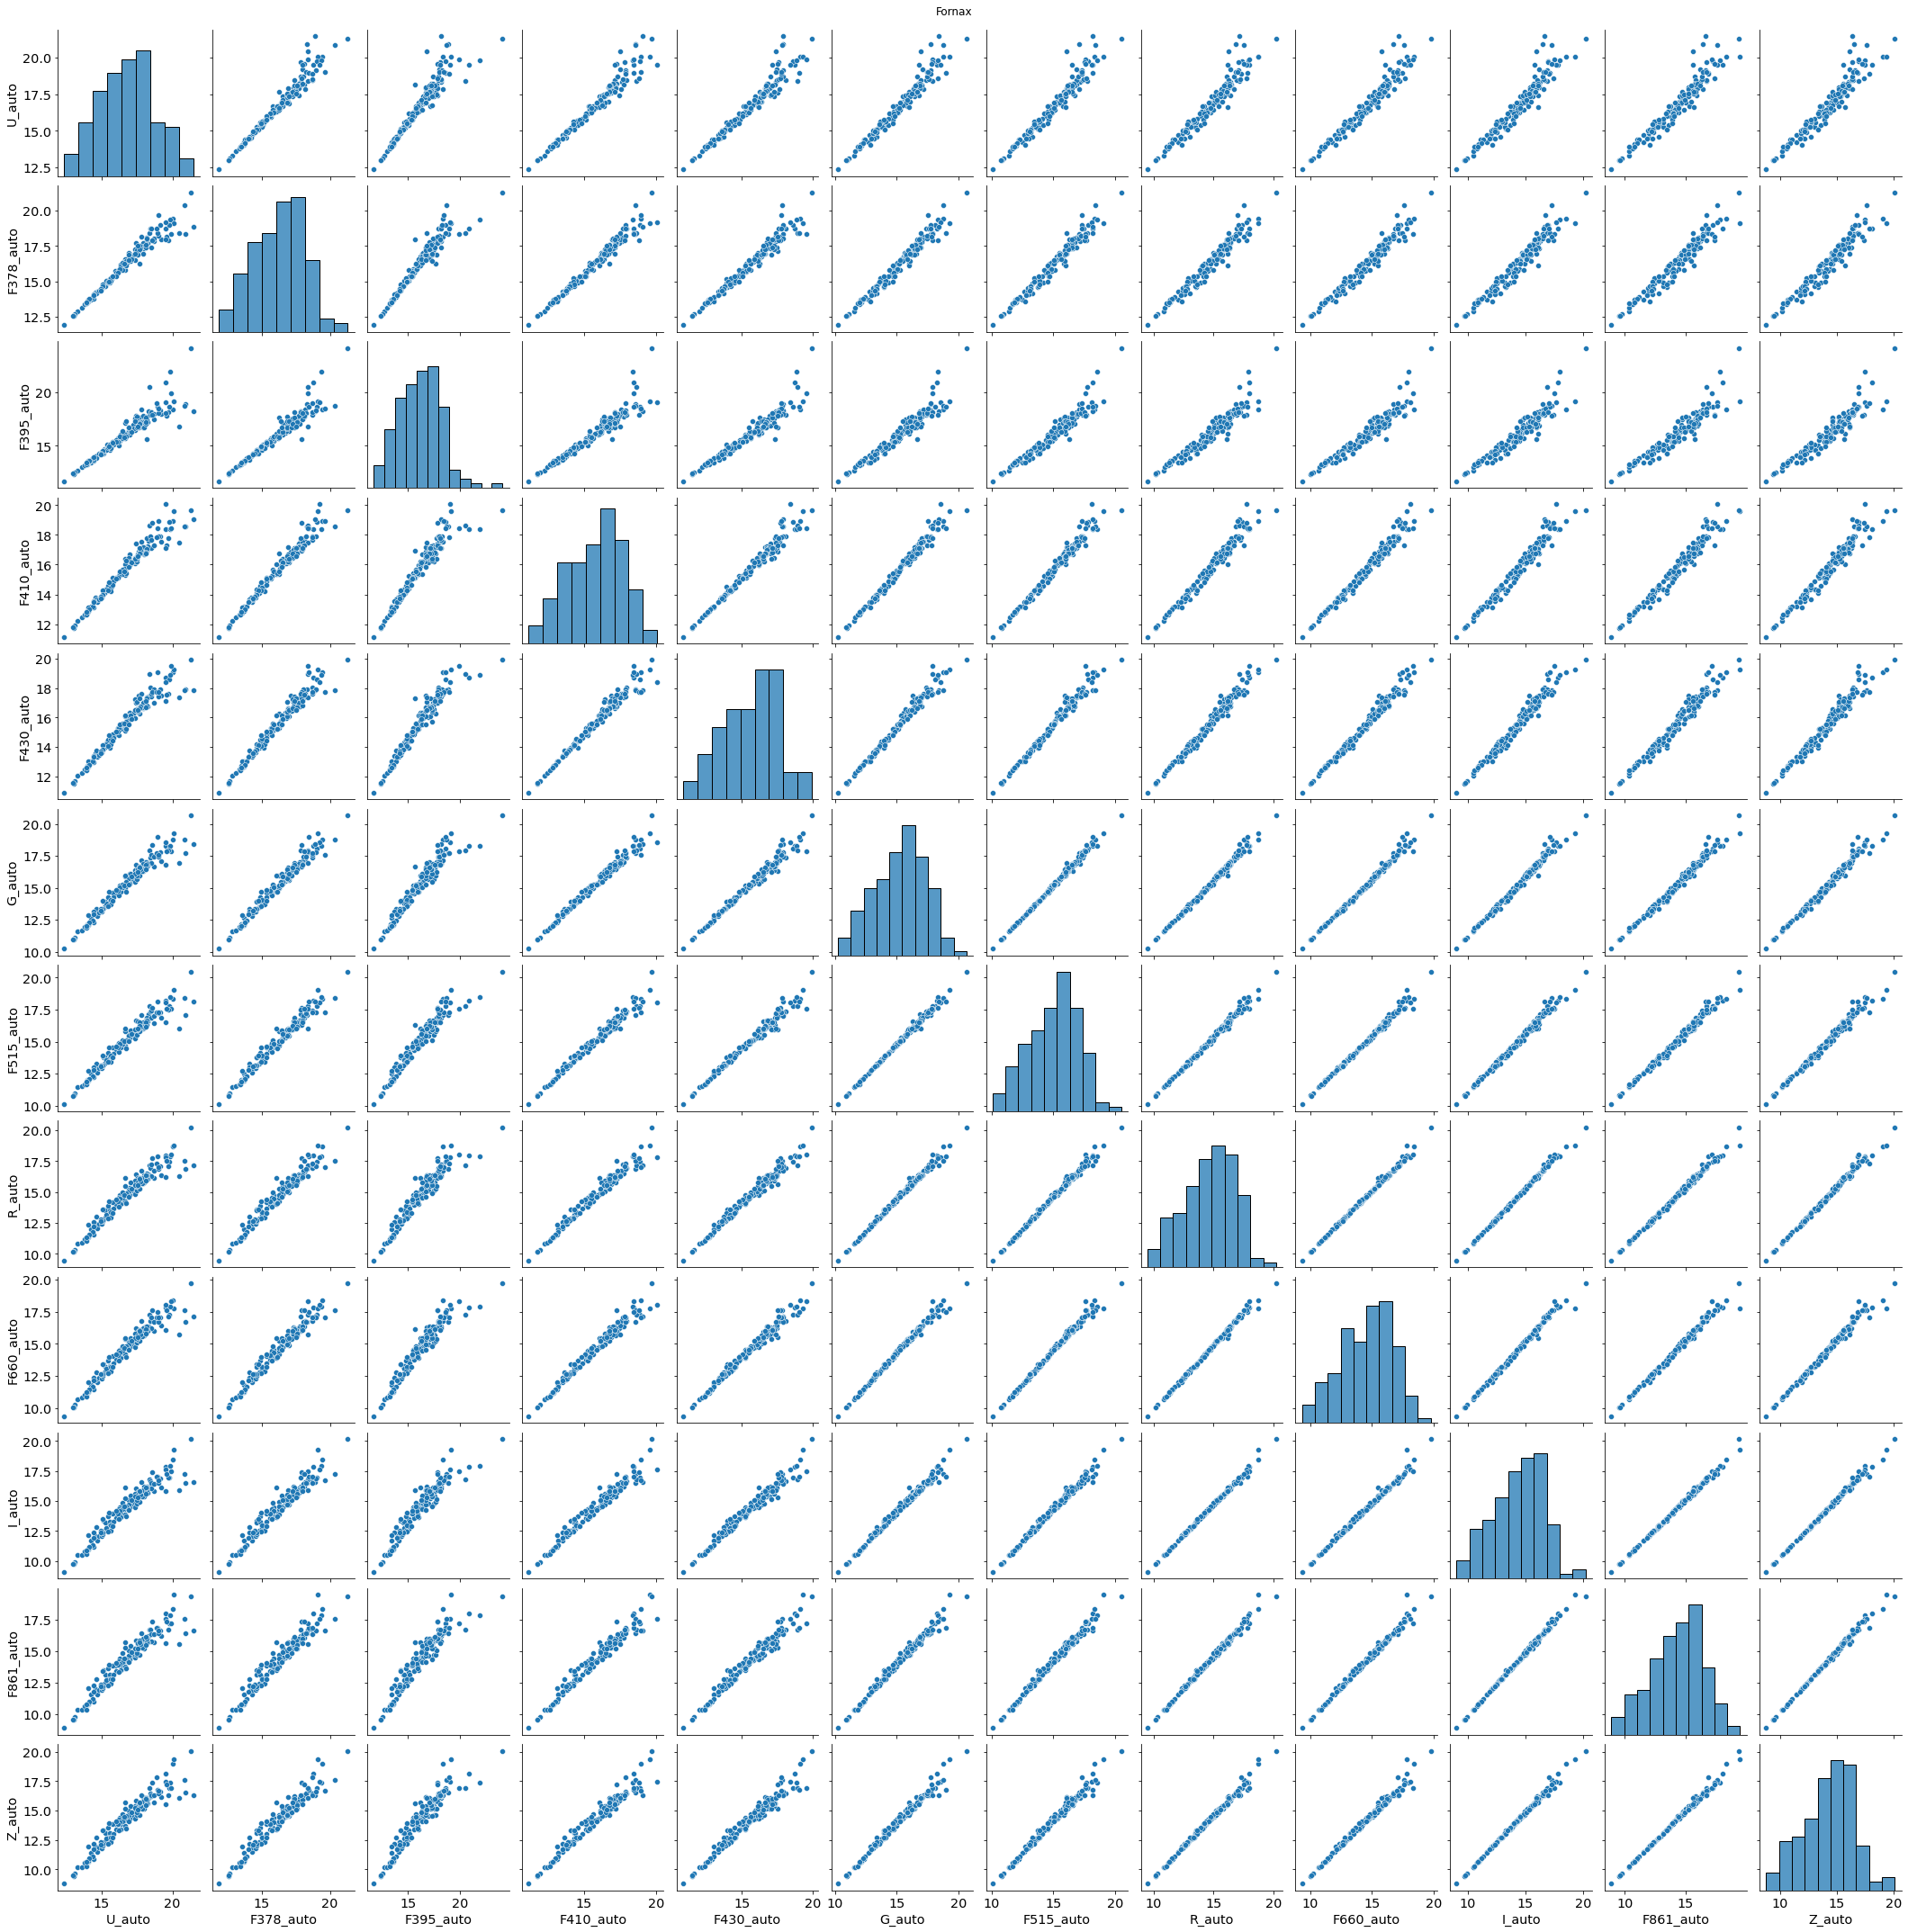

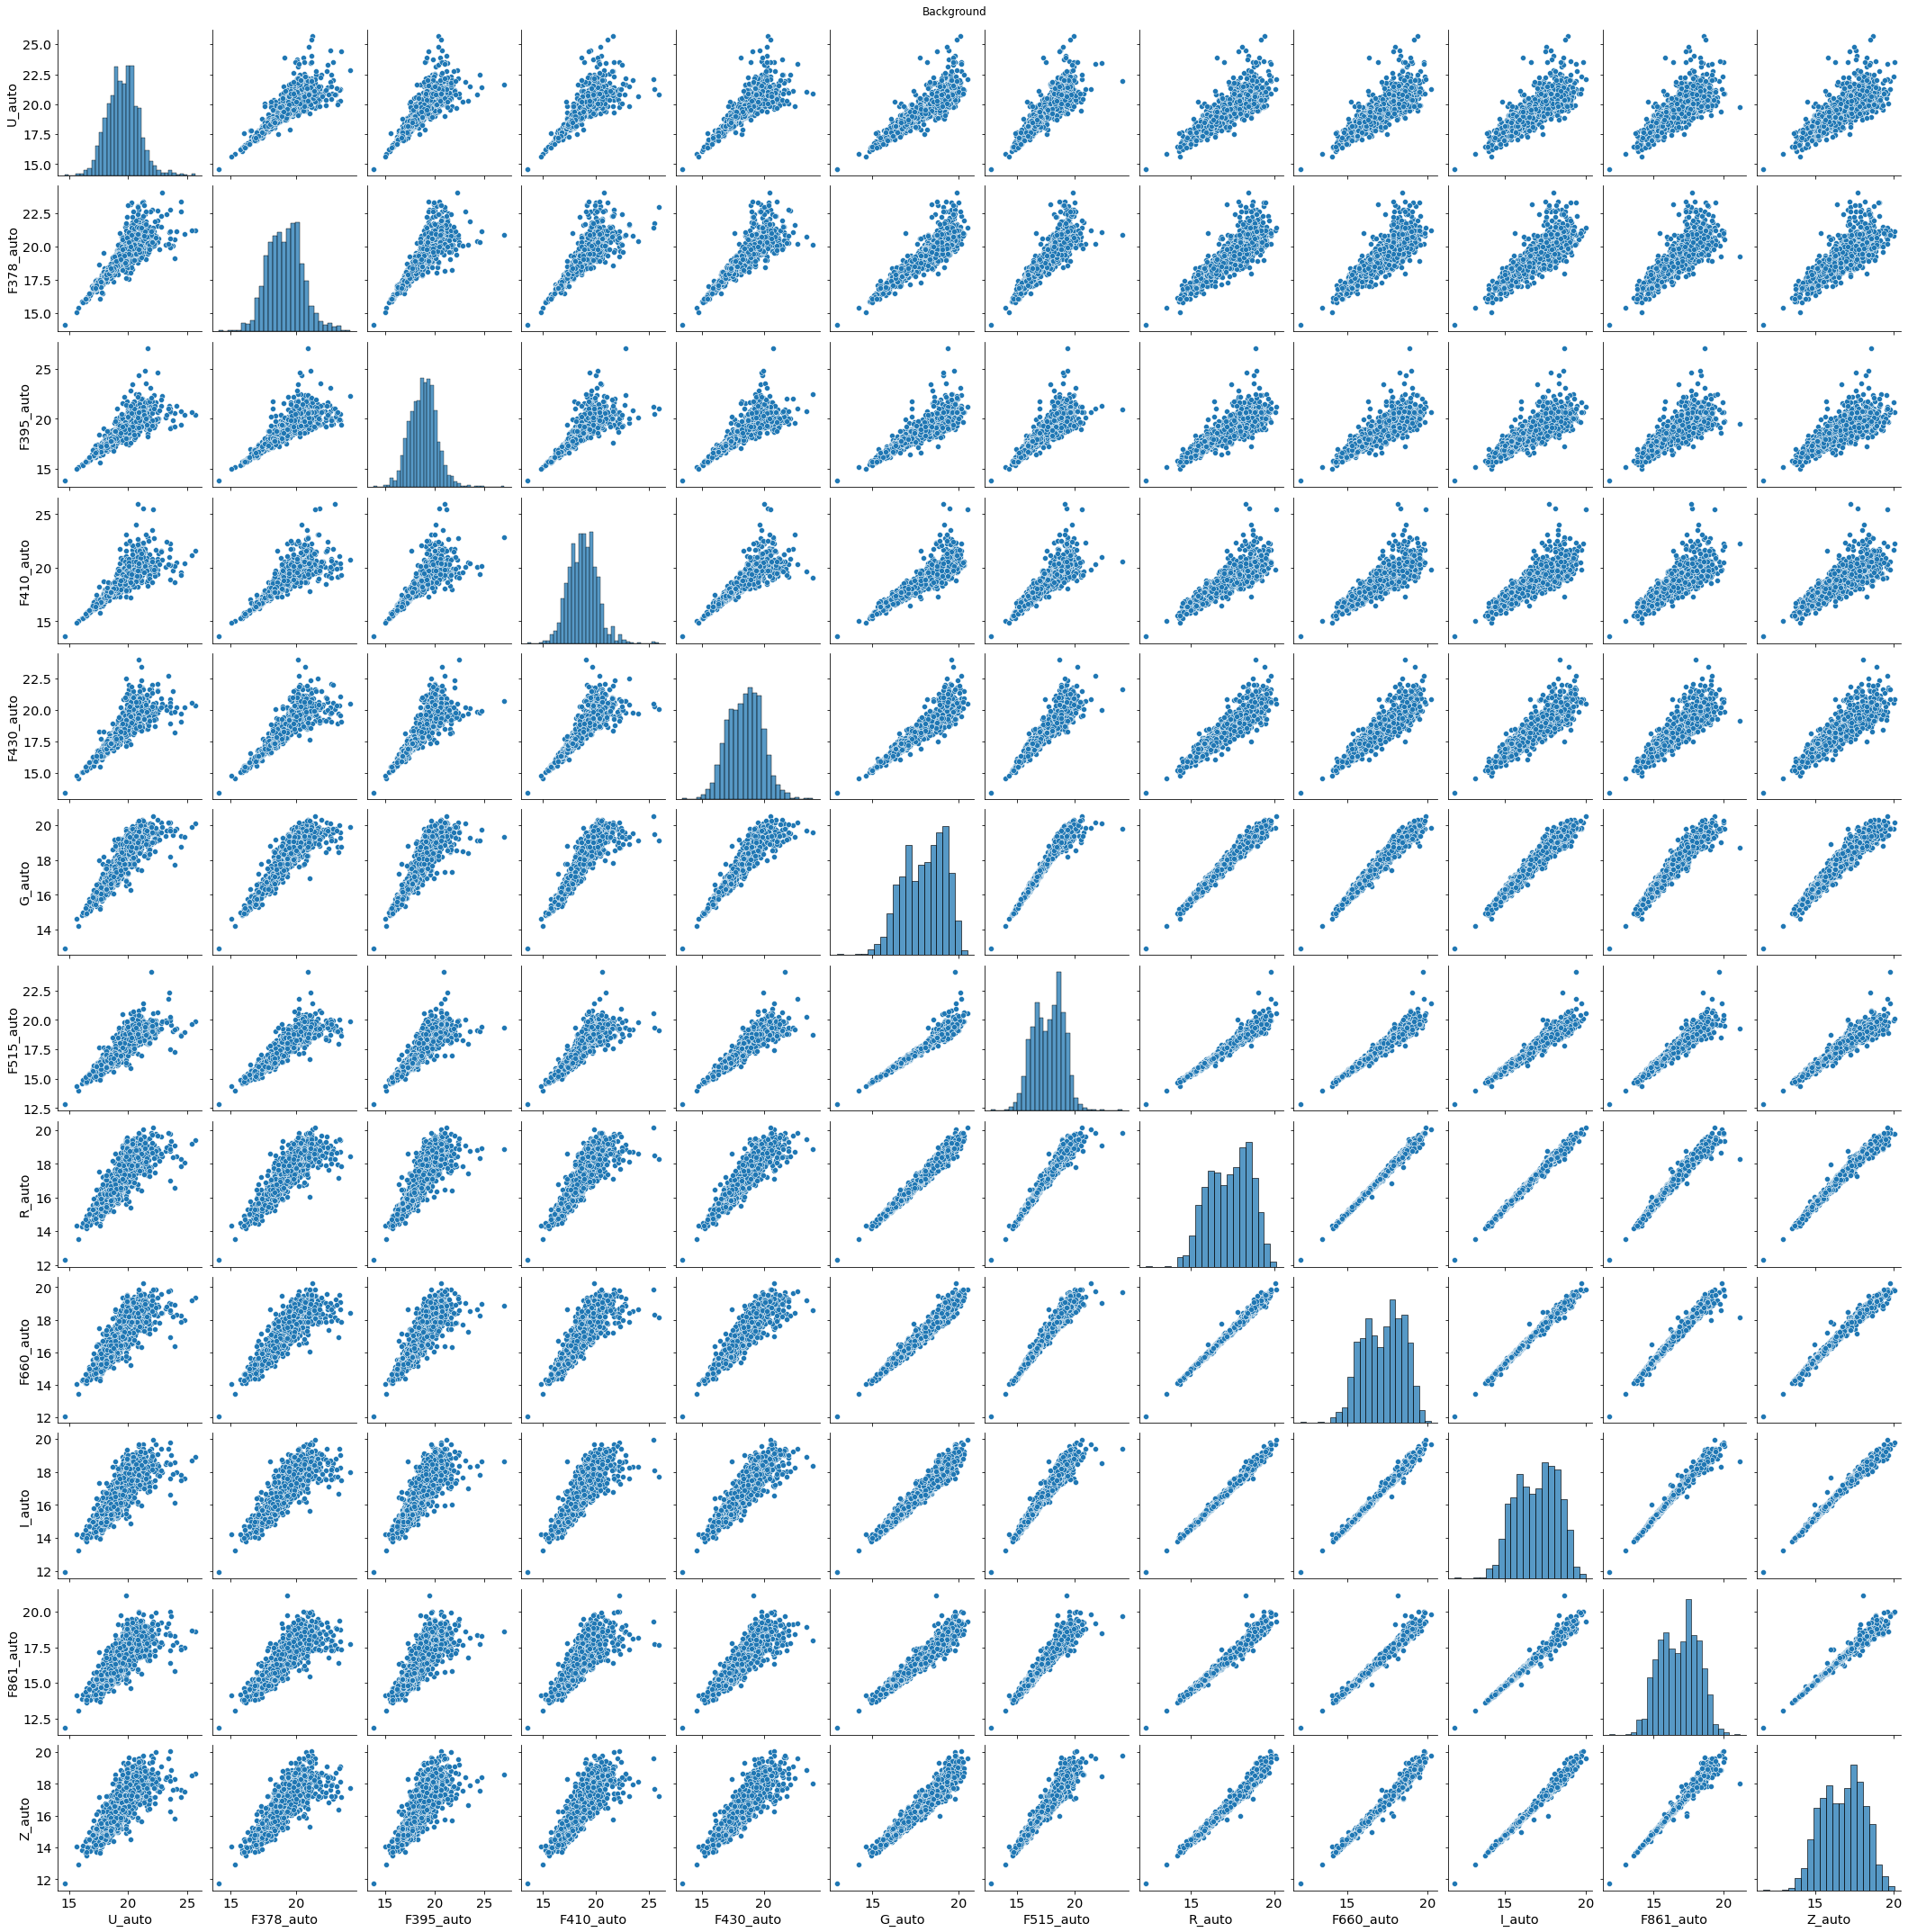

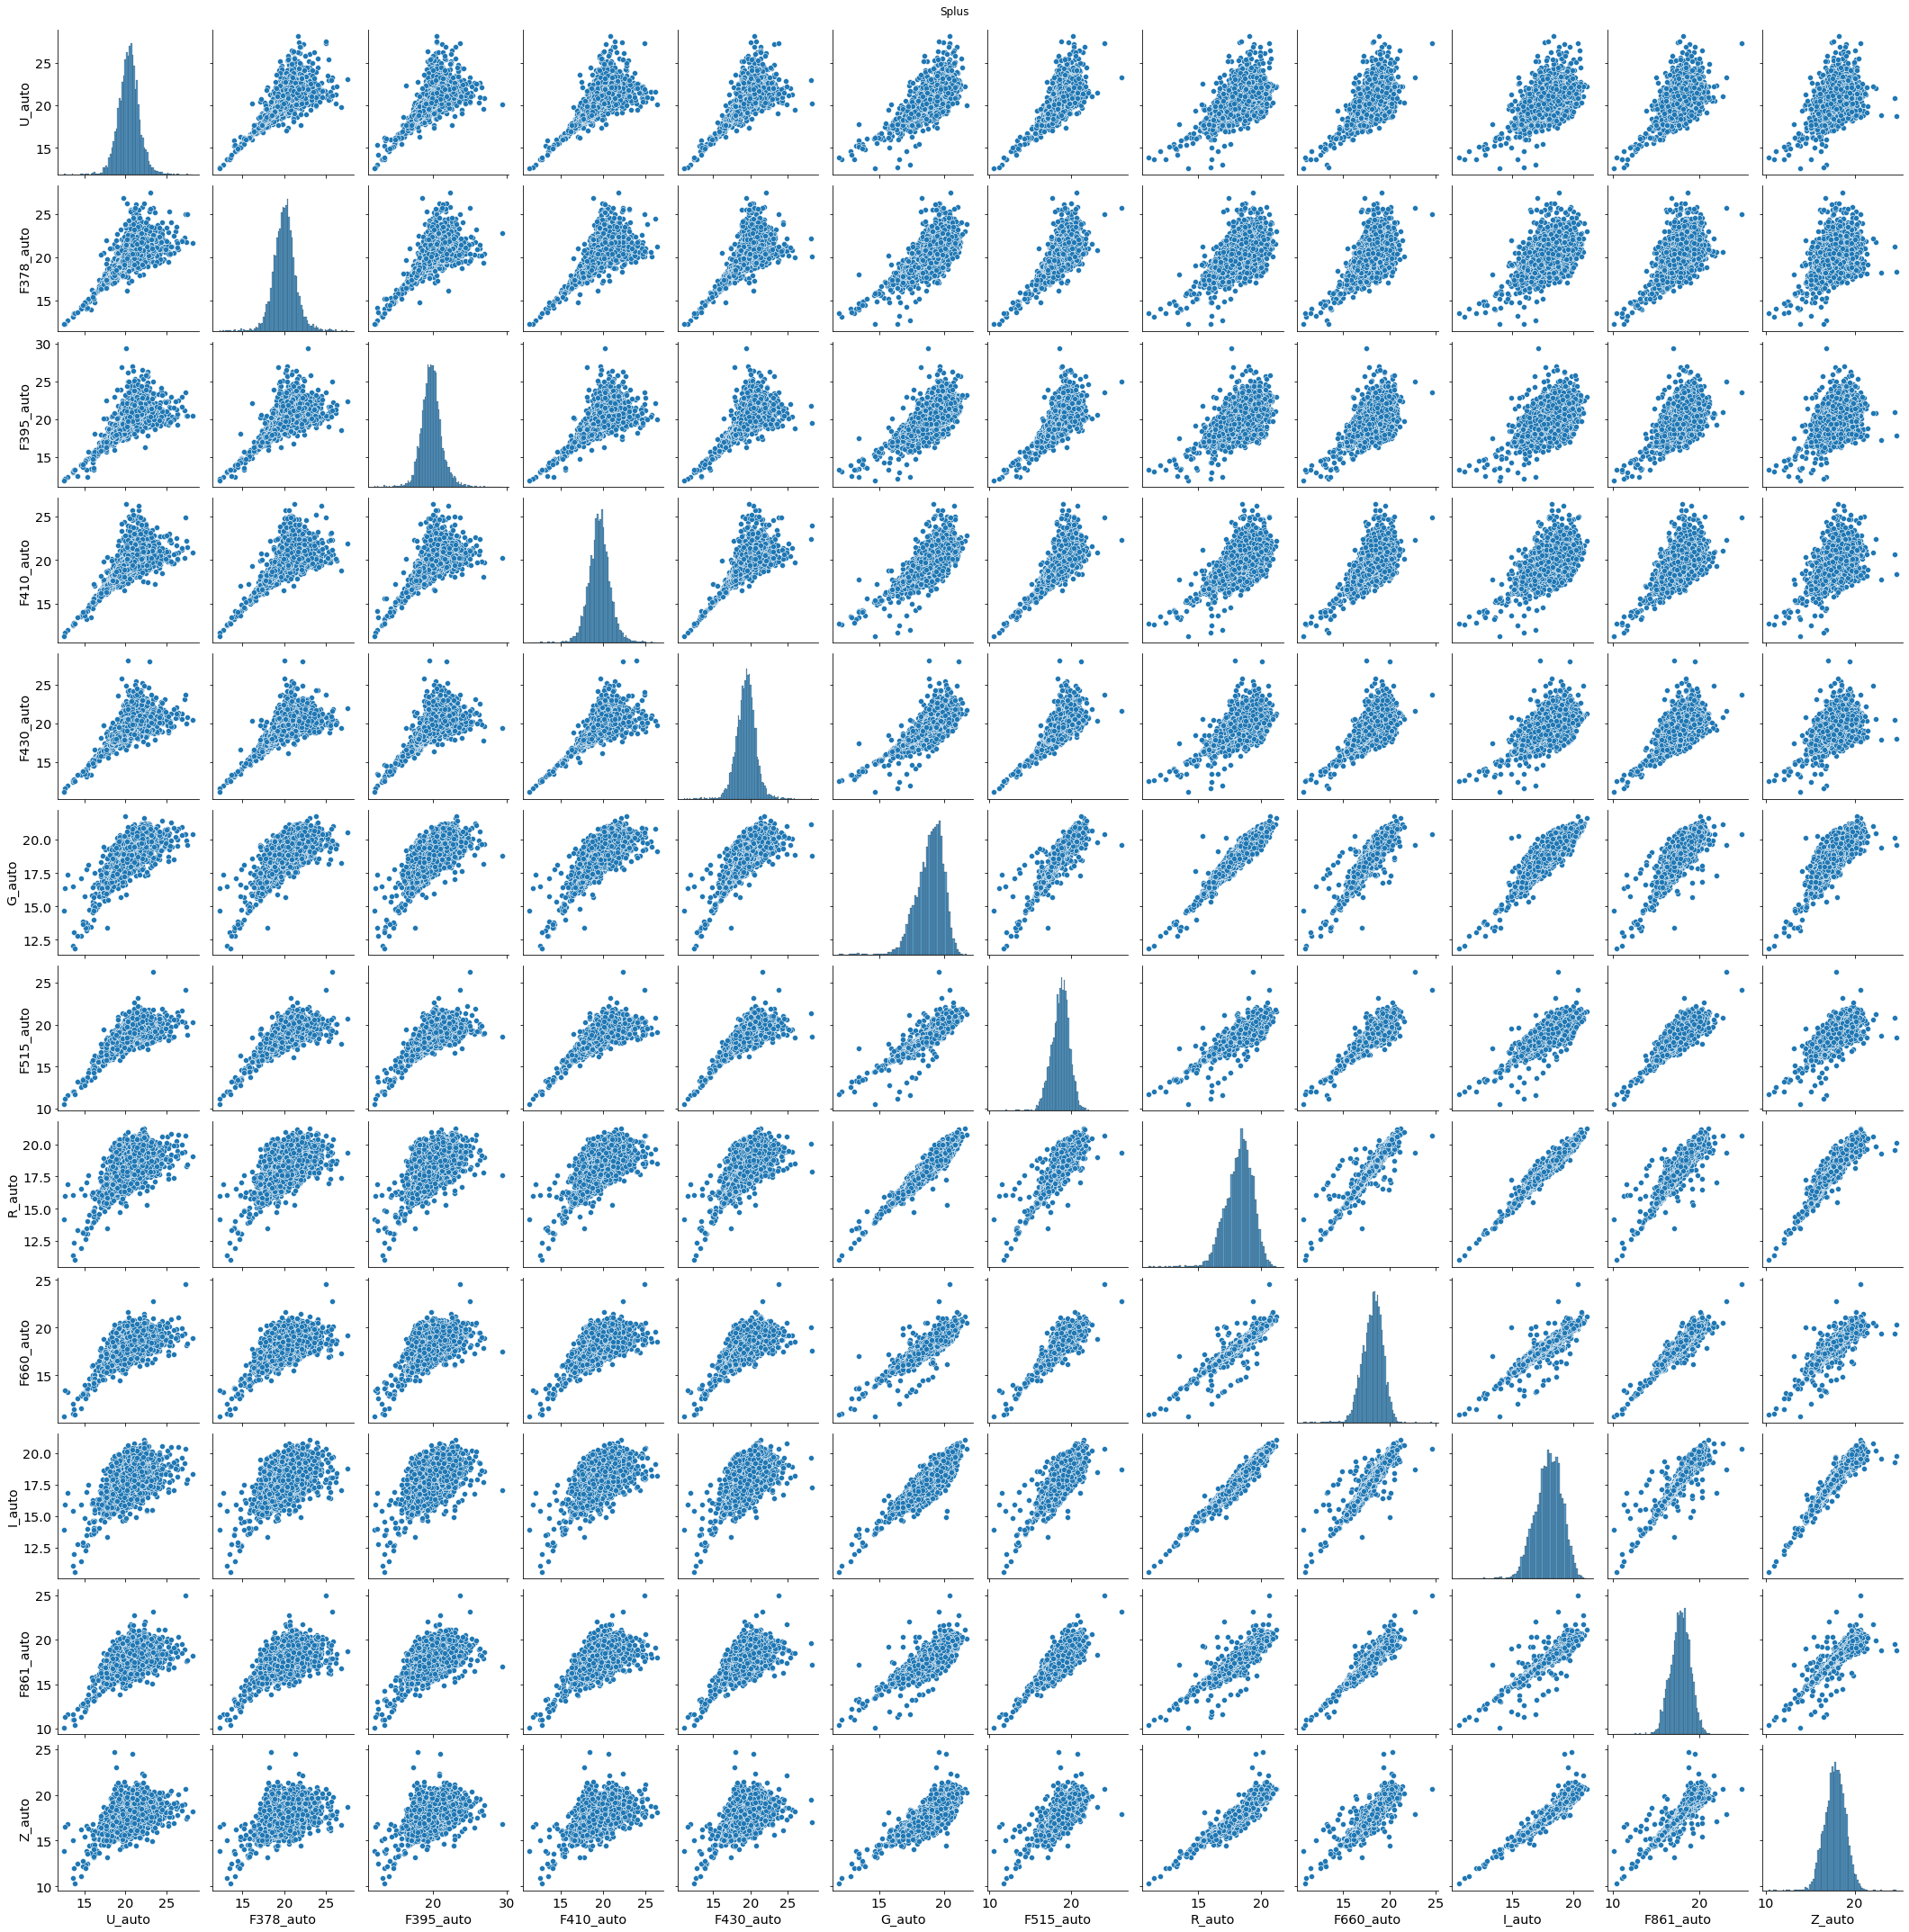

In [121]:
for l in [ 'Fornax', 'Background', 'Splus' ]:
    print ( l )
    data = datos [ datos['label'] == l ][features]
    pp = sns.pairplot ( data = data )
    pp.fig.suptitle( l, y = 1.0 )

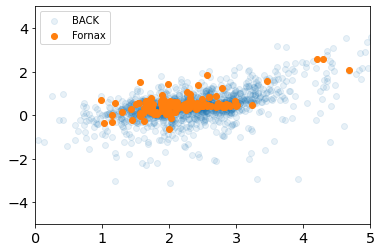

In [122]:
#plt.scatter (Splus['U_auto'], Splus['G_auto'], color="gray", alpha=0.3, label = "Splus")
plt.scatter (Background['U_auto']-Background['F660_auto'], Background['U_auto']-Background['F378_auto'], alpha = 0.1, label="BACK")
plt.scatter (Fornax['U_auto']-Fornax['F660_auto'], Fornax['U_auto']-Fornax['F378_auto'], label = "Fornax")
plt.xlim(0,5)
plt.ylim(-5,5)
plt.legend()

In [102]:
df = pd.DataFrame(components, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'] )

fig = px.scatter_3d(
        df, x = 'PC1', y = 'PC2', z = 'PC3', color=d['label']
)
fig.show()

ValueError: Shape of passed values is (5574, 12), indices imply (5574, 8)